[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Charlie5DH/Attention-Models/blob/master/ParametersSweep/Sweep.ipynb)

In [2]:
!nvidia-smi

Fri Oct 16 22:36:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
TF_CPP_MIN_LOG_LEVEL=2

In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

In [5]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
# this is for making Graphviz work (plot_model needs GraphViz)
from IPython.display import HTML

In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
# Block to load file depending if you are in Colab or in Jupyter
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !wget --no-check-certificate \
        https://www.dropbox.com/s/qbn9y5ooqxipxki/single_feature.csv?dl=0 \
        -O /tmp/Features.csv
        
    data = pd.read_csv('/tmp/Features.csv', parse_dates=['Timestamp'], index_col='Timestamp')
else:
    path_of_file = '../Data/single_feature.csv'
    data = pd.read_csv(path_of_file, parse_dates=['Timestamp'], index_col='Timestamp')

Running on CoLab
--2020-10-16 22:36:20--  https://www.dropbox.com/s/qbn9y5ooqxipxki/single_feature.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qbn9y5ooqxipxki/single_feature.csv [following]
--2020-10-16 22:36:20--  https://www.dropbox.com/s/raw/qbn9y5ooqxipxki/single_feature.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7bb01a44db143db479869522ad.dl.dropboxusercontent.com/cd/0/inline/BBYW1i9UHcVvzCw3ngLDnBayDKghUXHd0E7DiO-FkV-U9B8jVPCvAxNB0xs0wgjLIlKX841T9VQerchfqvJOk5GpFYIqLUo2vUIFpQHdZ5us6smqskBB9tj1bIZjOugoySA/file# [following]
--2020-10-16 22:36:21--  https://uc7bb01a44db143db479869522ad.dl.dropboxusercontent.com/cd/0/inline/BBYW1i9UHcVvzCw3ngLDnBayDKghUXHd0E7DiO-FkV-U9B8jVPCvAxNB0xs0wgjLIlKX841T9V

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
# The data is higly irregular so let's resample it to 10 min and take the mean
resampled = data.resample('30Min').mean()
resampled = resampled.fillna(resampled.bfill())
# Now let's take only a slice of it

init_date = '2019-03'
train_end_date = '2019-10-25'
end_date = '2019-04-20'
#Separate Train and test
train_data = resampled[init_date:end_date]

train_ratio = 0.8
train_len = int(train_ratio*len(train_data))
scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(train_data)
print('Lenght of Data {}'.format(len(normalized_train)))
print('Lenght of Train {}'.format(train_len))

Lenght of Data 2448
Lenght of Train 1958


In [10]:
def split_sequences_multivariate(sequences, n_steps=32):
    
    '''
    Split a multivariate sequence into samples for single feature prediction
    Taken and adapted from Machinelearningmastery.
    Split the training set into segments of a specified timestep
    and creates the labels.
    '''
    #n_steps = n_steps+1
    # Place the column of the feature to predict at the end of the dataset
    #sequences = np.concatenate([X_train, X_train[:,0].reshape(-1,1)],axis=1)
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    
    #print(np.shape(X),np.shape(y))
    return np.array(X), np.array(y)

In [11]:
def Model_lstm(units, input_shape, dropout):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(units=units, input_shape=input_shape,
                                      return_sequences=True, dropout=dropout))
  model.add(tf.keras.layers.LSTM(units=units, input_shape=input_shape,
                                      return_sequences=False, dropout=dropout))
  #model_LSTM.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(n_features))
  return model

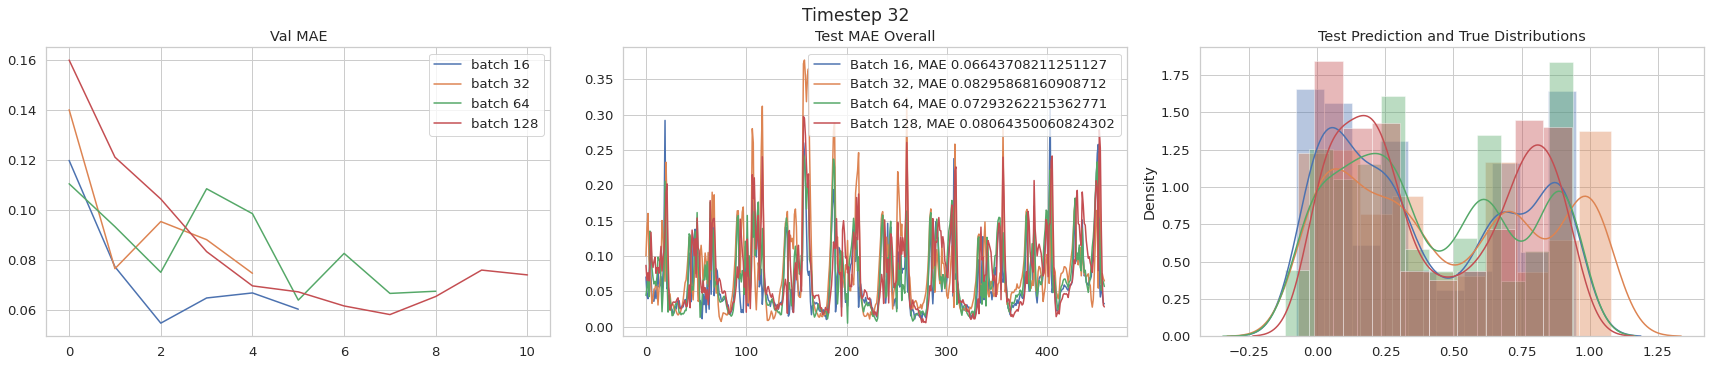

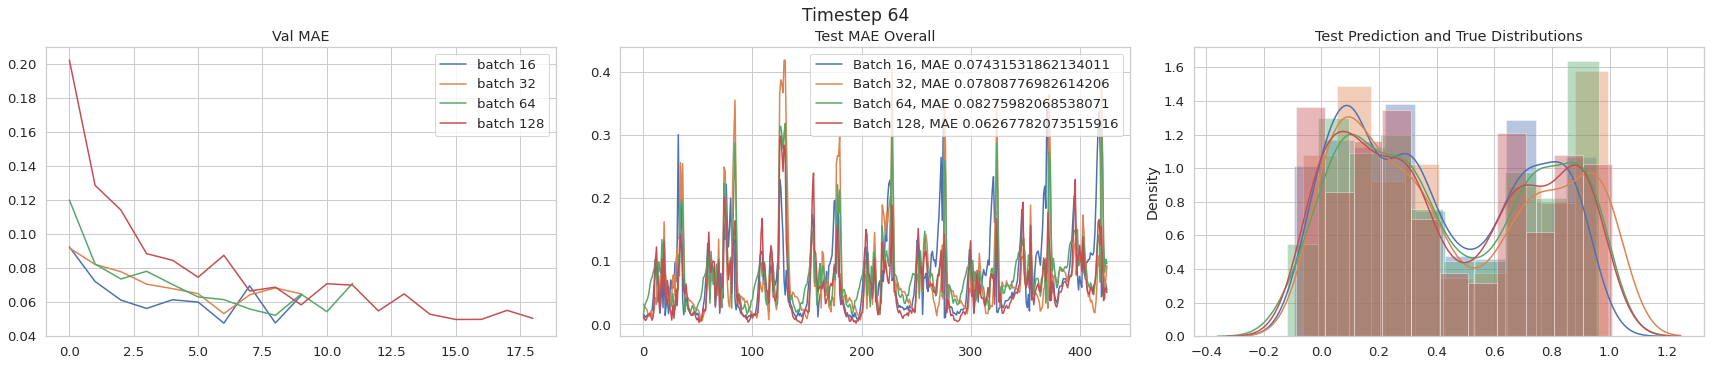

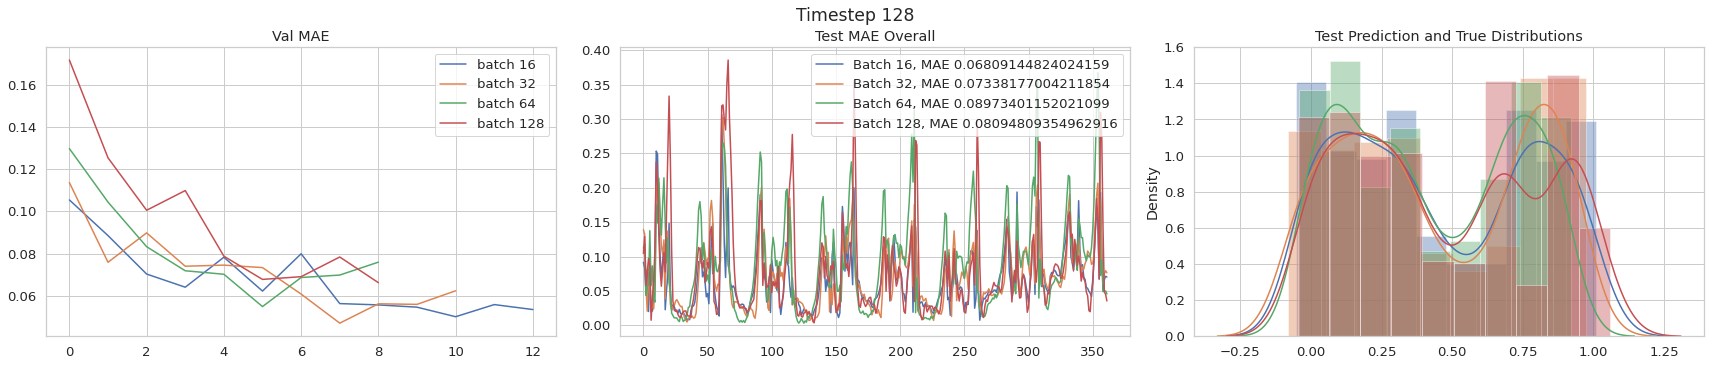

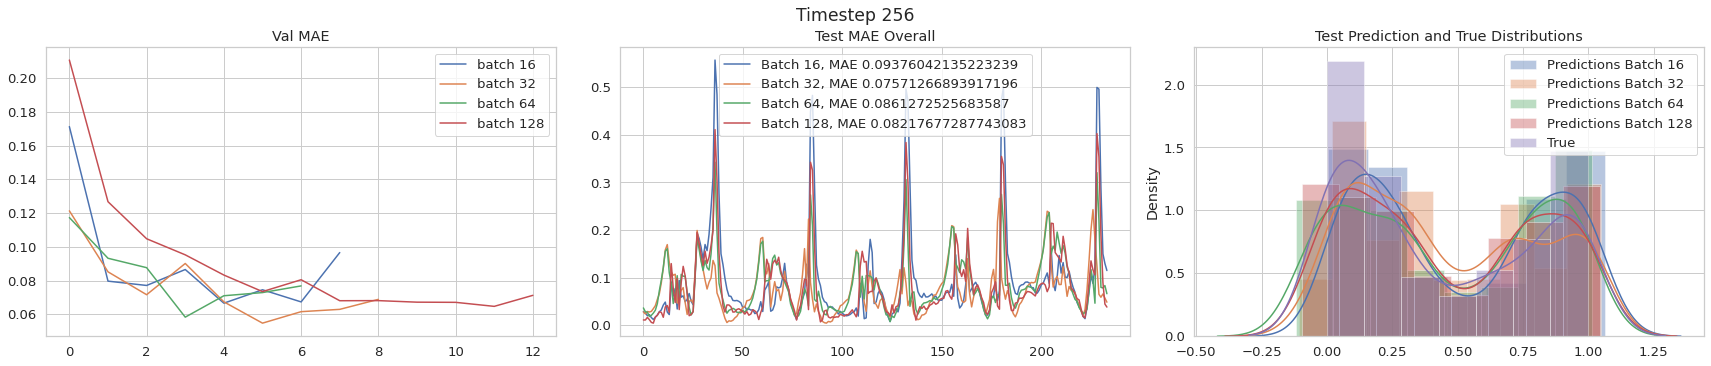

In [24]:
n_timesteps = [32, 64, 128, 256]
n_features = normalized_train.shape[-1]
batches = [16,32,64,128]
history_list = []
model_list = []

train_predictions_list = []
test_predictions_list = []
MAE_train = []
MAE_test = []
mae_overall_train_list = []
mae_overall_test_list = []
results_list = []

for timestep in n_timesteps:
  fig, axx = plt.subplots(1,3, figsize=(24,5))
  for batch in batches:
    train_X, train_y = split_sequences_multivariate(normalized_train[:train_len], n_steps=timestep)
    test_X, test_y = split_sequences_multivariate(normalized_train[train_len:], n_steps=timestep)
    #print('Training Shapes. X{}, y{} '.format(train_X_lstm.shape, train_y_lstm.shape))
    #print('Testing Shapes. X{}, y{} '.format(test_X_lstm.shape, test_y_lstm.shape))
    model = Model_lstm(units=128, input_shape=(timestep, n_features), dropout=0.2)
    
    optimizer = tf.keras.optimizers.Adam(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    model_list.append(model)

    early_stop = EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(train_X, train_y,
                        validation_split=0.2, 
                        epochs=100, verbose=0,
                        callbacks=[early_stop], 
                        batch_size=batch)
    
    history_df = pd.DataFrame(history.history, columns=['mae', 'val_mae'])
    history_list.append(history_df)

    predict_train = model.predict(train_X)
    predict_test = model.predict(test_X)
    MAE_train = abs(predict_train - train_y).mean()
    mae_overall_train = (abs(predict_train-train_y).mean(axis=(1)))
    MAE_test = (abs(predict_test - test_y).mean())
    mae_overall_test = abs(predict_test-test_y).mean(axis=(1))

    trainPredictions_df = pd.DataFrame(np.column_stack([predict_train, train_y, mae_overall_train]),
                                  columns=['Temp_pred','VMPPT_pred','VPan_pred','Temp_true','VMPPT_true','VPan_true', 'MAE_O Train'])
    
    testPredictions_df = pd.DataFrame(np.column_stack([predict_test, test_y, mae_overall_test]),
                                      columns=['Temp_pred','VMPPT_pred','VPan_pred','Temp_true','VMPPT_true','VPan_true', 'MAE_O Train'])
    
    trainPredictions_df[['MAE train']] = MAE_train
    testPredictions_df[['MAE test']] = MAE_test

    fig.suptitle('Timestep {}'.format(timestep), y=1.02)
    #history_df['mae'].plot(ax=axx[0], label=('batch {}'.format(batch)), title='Train MAE')
    history_df['val_mae'].plot(ax=axx[0], label=('batch {}'.format(batch)), title='Val MAE')
    #axx[2].plot(mae_overall_train, label=('Batch {}, MAE {}'.format(batch, MAE_train)))
    #axx[2].set_title('Train MAE Overall')
    axx[1].plot(mae_overall_test, label=('Batch {}, MAE {}'.format(batch, MAE_test)))
    axx[1].set_title('Test MAE Overall')
    sns.distplot(a=predict_test.flatten(), ax=axx[2], label='Predictions Batch {}'.format(batch))
    axx[2].set_title('Test Prediction and True Distributions')
    axx[0].legend();axx[2].legend(); axx[1].legend()
    #axx[3].legend()
    plt.tight_layout()

    results_list.append(('Batch {}, Timesetps {}, MAE in Training Set {}'.format(batch,timestep,MAE_train)))
    results_list.append(('Batch {}, Timesetps {}, MAE in Testing Set {}'.format(batch,timestep,MAE_test)))

    train_predictions_list.append(trainPredictions_df)
    test_predictions_list.append(testPredictions_df)

sns.distplot(a=test_y.flatten(), ax=axx[2], label= 'True')
axx[2].legend()

In [ ]:
results_list    

# Parameter Sweep with Seq to Seq

In [12]:
# split a multivariate sequence into samples
def multi_step_output(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [13]:
def Model_Seq(n_hidden, input_shape, output_shape, dropout):

  input_train = Input(shape=input_shape)
  output_train = Input(shape=output_shape)

  encoder_last_h1, encoder_last_h2, encoder_last_c = \
  tf.keras.layers.LSTM(n_hidden, activation='relu', dropout=dropout,
                       return_sequences=False,
                       return_state=True)(input_train)

  # Batch normalisation is added because we want to avoid gradient
  # explosion caused by the activation function ELU in the encoder.
  #encoder_last_h1 = BatchNormalization(momentum=0.9)(encoder_last_h1)
  #encoder_last_c = BatchNormalization(momentum=0.9)(encoder_last_c)

  # Create copies of las hidden state
  decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)

  # nitial_state: List of initial state tensors to be passed to the first call of the cell 
  #(optional, defaults to None which causes creation of zero-filled initial state tensors).
  # In this case initial state is the output from encoder
  decoder = tf.keras.layers.LSTM(n_hidden, activation='relu', dropout=dropout,
                                return_state=False,
                                return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

  out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
  model = tf.keras.Model(inputs=input_train, outputs=out)
  return model

In [23]:
def get_results_df(results_dict):
  results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MAE'])

  indexx = []
  for ii in np.arange(0, results_df.shape[0], 2):
    indexx.append(results_df.index[ii])
  train_results_df = results_df.loc[indexx]
  train_results_df['Train_Params'] = train_results_df.index
  train_results_df = train_results_df.set_index(np.arange(0,results_df.shape[0]/2))
  train_results_df = train_results_df[['Train_Params', 'MAE']]

  indexx = []
  for ii in np.arange(1, results_df.shape[0], 2):
    indexx.append(results_df.index[ii])

  test_results_df = results_df.loc[indexx]
  test_results_df['Test_Params'] = test_results_df.index
  test_results_df = test_results_df.set_index(np.arange(0,results_df.shape[0]/2))
  test_results_df = test_results_df[['Test_Params', 'MAE']]

  results_df=pd.concat([train_results_df,test_results_df],axis=1)
  
  return results_df

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

n_timesteps_in = [32, 64, 128, 256]
n_features = normalized_train.shape[-1]
batches = [16,32,64,128]
horizons = [8,16,24,32,64]
history_list = []
model_list = []
results_list = []

train_predictions_list = []
test_predictions_list = []
MAE_train = []
MAE_test = []
mae_overall_train_list = []
mae_overall_test_list = []
results = {}

for timestep in n_timesteps_in:
  for batch in batches:
    #fig, axx = plt.subplots(1,3, figsize=(24,4))
    for horizon in horizons:
      train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=timestep, n_steps_out=horizon)
      test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=timestep, n_steps_out=horizon)

      model = Model_Seq(n_hidden=128, input_shape=(timestep, n_features),
                        output_shape=(horizon, n_features), dropout=0.2)
      
      optimizer = tf.keras.optimizers.Adam(lr=0.01)
      model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
      model_list.append(model)

      early_stop = EarlyStopping(monitor='val_loss', patience=3)

      history = model.fit(train_X, train_y,
                          validation_split=0.2, 
                          epochs=100, verbose=0,
                          callbacks=[early_stop], 
                          batch_size=batch)
      
      history_df = pd.DataFrame(history.history, columns=['mae', 'val_mae'])
      history_list.append(history_df)

      predict_train = model.predict(train_X)
      predict_test = model.predict(test_X)
      MAE_train = abs(predict_train - train_y).mean()
      mae_overall_train = (abs(predict_train-train_y).mean(axis=(1,2)))
      MAE_test = (abs(predict_test - test_y).mean())
      mae_overall_test = abs(predict_test-test_y).mean(axis=(1,2))

      #trainPredictions_df = pd.DataFrame(np.column_stack([predict_train, train_y, mae_overall_train]),
      #                              columns=['Temp_pred','VMPPT_pred','VPan_pred','Temp_true','VMPPT_true','VPan_true', 'MAE_O Train'])
      
      #testPredictions_df = pd.DataFrame(np.column_stack([predict_test, test_y, mae_overall_test]),
      #                                  columns=['Temp_pred','VMPPT_pred','VPan_pred','Temp_true','VMPPT_true','VPan_true', 'MAE_O Train'])
      
      #trainPredictions_df[['MAE train']] = MAE_train
      #testPredictions_df[['MAE test']] = MAE_test
      results_list.append(('Timesetps {}, Batch {}, Horizon {}, MAE in Training Set {}'.format(timestep,batch,horizon,MAE_train)))
      results_list.append(('Timesetps {}, Batch {}, Horizon {}, MAE in Testing Set {}'.format(timestep,batch,horizon,MAE_test)))
      
      name = ('T_{}_B_{}_H_{}_train'.format(timestep,batch,horizon))
      results.update({name:MAE_train})
      name = ('T_{}_B_{}_H_{}_test'.format(timestep,batch,horizon))
      results.update({name:MAE_test})
      
      #fig.suptitle('Timestep {}, Batch {}'.format(timestep, batch), y=1.02)
      #history_df['val_mae'].plot(ax=axx[0], label=('horizon {},batch {}'.format(horizon, batch)), title='Val MAE')
      #axx[1].plot(mae_overall_test, label=('hor {}, MAE {}'.format(horizon, MAE_test)))
      #axx[1].set_title('Test MAE Overall')
      #sns.distplot(a=predict_test.flatten(), ax=axx[2], label='Prediction')
      #sns.distplot(a=test_y.flatten(), ax=axx[2], label= 'True')
      #axx[2].set_title('Test Prediction and True Distributions')
      #axx[0].legend(); axx[1].legend()
      #axx[2].legend(); #axx[3].legend()
      #plt.tight_layout()
    #print(batch)
    #sns.distplot(a=test_y.flatten(), ax=axx[2], label= 'True')
    #axx[2].legend()
    #plt.tight_layout()
  


In [25]:
results_df = get_results_df(results)
results_df.to_csv('/tmp/results_seq2seq.csv', columns=['Train_Params', 'MAE',	'Test_Params',	'MAE'])
results_df

,Train_Params,MAE,Test_Params,MAE
0.0,T_32_B_16_H_8_train,0.068516,T_32_B_16_H_8_test,0.081976
1.0,T_32_B_16_H_16_train,0.058736,T_32_B_16_H_16_test,0.075955
2.0,T_32_B_16_H_24_train,0.078578,T_32_B_16_H_24_test,0.080076
3.0,T_32_B_16_H_32_train,0.087427,T_32_B_16_H_32_test,0.098758
4.0,T_32_B_16_H_64_train,0.317771,T_32_B_16_H_64_test,0.324124
...,...,...,...,...
75.0,T_256_B_128_H_8_train,0.074005,T_256_B_128_H_8_test,0.085889
76.0,T_256_B_128_H_16_train,NaN,T_256_B_128_H_16_test,NaN
77.0,T_256_B_128_H_24_train,NaN,T_256_B_128_H_24_test,NaN
78.0,T_256_B_128_H_32_train,0.084909,T_256_B_128_H_32_test,0.098647


In [29]:
def Model_Attention(n_hidden, input_shape, output_shape, dropout):

  input_train = Input(shape=input_shape)
  output_train = Input(shape=output_shape)

    # The encoder now returns
  encoder_stack_h, encoder_last_h, encoder_last_c = tf.keras.layers.LSTM(n_hidden, activation='tanh',
                                                                        dropout=0.2, return_sequences=True, 
                                                                        return_state=True)(input_train)

  # Adding Batch Regularization to avoid gradient explotion(optional)
  #encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
  #encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

  # Repeat the last hidden state of encoder 20 times, and use them as input to decoder LSTM.
  decoder_input = tf.keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h)

  decoder_stack_h = tf.keras.layers.LSTM(n_hidden, activation='tanh',
                                        dropout=0.2, recurrent_dropout=0.2, return_state=False,
                                        return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

    # Alignment Score is Dot Product in Luong Attention
  attention = tf.keras.layers.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
  attention = tf.keras.layers.Activation('softmax', name='Softmax')(attention)
  #print(attention)

  context = tf.keras.layers.dot([attention, encoder_stack_h], axes=[2,1])
  #context = BatchNormalization(momentum=0.6)(context)
  #print(context)

  # Now we concat the context vector and stacked hidden states of decoder, 
  # and use it as input to the last dense layer.
  decoder_combined_context = tf.keras.layers.concatenate([context, decoder_stack_h])
  #print(decoder_combined_context)

  out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_train.shape[2]))(decoder_combined_context)
  model = tf.keras.models.Model(inputs=input_train, outputs=out)
  
  return model

In [30]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

n_timesteps_in = [32, 64, 128, 256]
n_features = normalized_train.shape[-1]
batches = [16,32,64,128]
horizons = [8,16,24,32,64]
history_list = []
model_list = []
results_list = []

train_predictions_list = []
test_predictions_list = []
MAE_train = []
MAE_test = []
mae_overall_train_list = []
mae_overall_test_list = []
results = {}

for timestep in n_timesteps_in:
  for batch in batches:
    #fig, axx = plt.subplots(1,3, figsize=(24,4))
    for horizon in horizons:
      train_X, train_y = multi_step_output(normalized_train[:train_len], n_steps_in=timestep, n_steps_out=horizon)
      test_X, test_y = multi_step_output(normalized_train[train_len:], n_steps_in=timestep, n_steps_out=horizon)

      model = Model_Attention(n_hidden=128, input_shape=(timestep, n_features),
                              output_shape=(horizon, n_features), dropout=0.2)
      
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1)
      model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
      model_list.append(model)

      early_stop = EarlyStopping(monitor='val_loss', patience=3)

      history = model.fit(train_X, train_y,
                          validation_split=0.2, 
                          epochs=100, verbose=0,
                          callbacks=[early_stop], 
                          batch_size=batch)
      
      history_df = pd.DataFrame(history.history, columns=['mae', 'val_mae'])
      history_list.append(history_df)

      predict_train = model.predict(train_X)
      predict_test = model.predict(test_X)
      MAE_train = abs(predict_train - train_y).mean()
      mae_overall_train = (abs(predict_train-train_y).mean(axis=(1,2)))
      MAE_test = (abs(predict_test - test_y).mean())
      mae_overall_test = abs(predict_test-test_y).mean(axis=(1,2))

      #trainPredictions_df = pd.DataFrame(np.column_stack([predict_train, train_y, mae_overall_train]),
      #                              columns=['Temp_pred','VMPPT_pred','VPan_pred','Temp_true','VMPPT_true','VPan_true', 'MAE_O Train'])
      
      #testPredictions_df = pd.DataFrame(np.column_stack([predict_test, test_y, mae_overall_test]),
      #                                  columns=['Temp_pred','VMPPT_pred','VPan_pred','Temp_true','VMPPT_true','VPan_true', 'MAE_O Train'])
      
      #trainPredictions_df[['MAE train']] = MAE_train
      #testPredictions_df[['MAE test']] = MAE_test
      results_list.append(('Timesetps {}, Batch {}, Horizon {}, MAE in Training Set {}'.format(timestep,batch,horizon,MAE_train)))
      results_list.append(('Timesetps {}, Batch {}, Horizon {}, MAE in Testing Set {}'.format(timestep,batch,horizon,MAE_test)))
      
      name = ('T_{}_B_{}_H_{}_train'.format(timestep,batch,horizon))
      results.update({name:MAE_train})
      name = ('T_{}_B_{}_H_{}_test'.format(timestep,batch,horizon))
      results.update({name:MAE_test})
      
      #fig.suptitle('Timestep {}, Batch {}'.format(timestep, batch), y=1.02)
      #history_df['val_mae'].plot(ax=axx[0], label=('horizon {},batch {}'.format(horizon, batch)), title='Val MAE')
      #axx[1].plot(mae_overall_test, label=('hor {}, MAE {}'.format(horizon, MAE_test)))
      #axx[1].set_title('Test MAE Overall')
      #sns.distplot(a=predict_test.flatten(), ax=axx[2], label='Prediction')
      #sns.distplot(a=test_y.flatten(), ax=axx[2], label= 'True')
      #axx[2].set_title('Test Prediction and True Distributions')
      #axx[0].legend(); axx[1].legend()
      #axx[2].legend(); #axx[3].legend()
      #plt.tight_layout()
    #print(batch)
    #sns.distplot(a=test_y.flatten(), ax=axx[2], label= 'True')
    #axx[2].legend()
    #plt.tight_layout()

results_df = get_results_df(results)
results_df.to_csv('/tmp/results_Att.csv', columns=['Train_Params', 'MAE',	'Test_Params',	'MAE'])
results_df

,Train_Params,MAE,Test_Params,MAE
0.0,T_32_B_16_H_8_train,0.063369,T_32_B_16_H_8_test,0.077014
1.0,T_32_B_16_H_16_train,0.080117,T_32_B_16_H_16_test,0.089399
2.0,T_32_B_16_H_24_train,0.063919,T_32_B_16_H_24_test,0.070964
3.0,T_32_B_16_H_32_train,0.067589,T_32_B_16_H_32_test,0.074431
4.0,T_32_B_16_H_64_train,0.061801,T_32_B_16_H_64_test,0.073131
...,...,...,...,...
75.0,T_256_B_128_H_8_train,0.057695,T_256_B_128_H_8_test,0.067515
76.0,T_256_B_128_H_16_train,0.068095,T_256_B_128_H_16_test,0.080856
77.0,T_256_B_128_H_24_train,0.072896,T_256_B_128_H_24_test,0.077434
78.0,T_256_B_128_H_32_train,0.064434,T_256_B_128_H_32_test,0.079220
